In [1]:
#Google Driveのファイルを読み込む設定
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# [注意]ディレクトリは任意のディレクトリを参照すること
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Chapter15/')
!ls

AI-TECHGYM-15-1.ipynb	 AI-TECHGYM-15-2-Q.ipynb  download.sh
AI-TECHGYM-15-1-Q.ipynb  AI-TECHGYM-15-3.ipynb	  ml-100k
AI-TECHGYM-15-2.ipynb	 datasets		  ml-100k.zip


In [3]:
!sh download.sh

--2019-09-03 03:42:15--  http://files.grouplens.org/papers/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  14.5MB/s    in 0.3s    

2019-09-03 03:42:16 (14.5 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-100k/allbut.pl       
replace ml-100k/mku.sh? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  i

In [4]:
pip install fastFM

In [0]:
%matplotlib inline
from sklearn.model_selection import learning_curve
import numpy as np
from fastFM import als

from sklearn.feature_extraction import DictVectorizer
import numpy as np

In [6]:
import pandas as pd

# ユーザー情報の読み込み
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols)
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [7]:
# レーティング情報の読み込み
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols)
ratings['date'] = pd.to_datetime(ratings['unix_timestamp'],unit='s')
ratings.head()

,user_id,movie_id,rating,unix_timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36
3,244,51,2,880606923,1997-11-27 05:02:03
4,166,346,1,886397596,1998-02-02 05:33:16


In [8]:
# 映画情報の読み込み
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5), encoding = "latin1")
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [9]:
# 3つの情報をマージする
movie_rating = pd.merge(movies, ratings)
lens = pd.merge(movie_rating, users)
lens.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,date,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,1998-02-17 18:20:08,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,1998-02-17 18:07:27,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,1998-02-17 17:31:36,60,M,retired,95076


In [10]:
# 最も評価された25作品のタイトル
lens.title.value_counts()[:25]

Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Titanic (1997)      

In [11]:
# レーティングの数と平均で集計し、平均値でソートする
movie_stats = lens.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.sort_values(by=[('rating', 'mean')], ascending=False).head()

rating     
                                             size mean
title                                                 
They Made Me a Criminal (1939)                  1  5.0
Marlene Dietrich: Shadow and Light (1996)       1  5.0
Saint of Fort Washington, The (1993)            2  5.0
Someone Else's America (1995)                   1  5.0
Star Kid (1997)                                 3  5.0

In [12]:
# 100件以上の評価が付いている映画に絞って上位15件をチェックする
atleast_100 = movie_stats['rating']['size'] >=100
movie_stats[atleast_100].sort_values(by=[('rating', 'mean')], ascending=False)[:15]

rating          
                                         size      mean
title                                                  
Close Shave, A (1995)                     112  4.491071
Schindler's List (1993)                   298  4.466443
Wrong Trousers, The (1993)                118  4.466102
Casablanca (1942)                         243  4.456790
Shawshank Redemption, The (1994)          283  4.445230
Rear Window (1954)                        209  4.387560
Usual Suspects, The (1995)                267  4.385768
Star Wars (1977)                          583  4.358491
12 Angry Men (1957)                       125  4.344000
Citizen Kane (1941)                       198  4.292929
To Kill a Mockingbird (1962)              219  4.292237
One Flew Over the Cuckoo's Nest (1975)    264  4.291667
Silence of the Lambs, The (1991)          390  4.289744
North by Northwest (1959)                 179  4.284916
Godfather, The (1972)                     413  4.283293

Text(0, 0.5, 'count of rating')

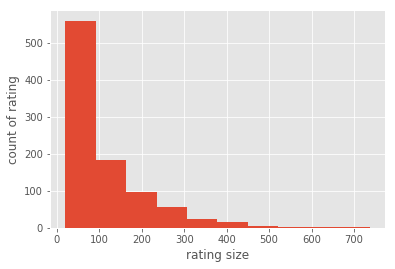

In [13]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

# user_idごとの評価数のヒストグラム
lens.groupby('user_id').size().sort_values(ascending=False).hist()

plt.xlabel('rating size')
plt.ylabel('count of rating')

In [14]:
# ユーザー毎の評価数と評価の平均の統計情報
user_stats = lens.groupby('user_id').agg({'rating': [np.size, np.mean]})
user_stats['rating'].describe()

,size,mean
count,943.000000,943.000000
mean,106.044539,3.588191
std,100.931743,0.445233
min,20.000000,1.491954
25%,33.000000,3.323054
50%,65.000000,3.620690
75%,148.000000,3.869565
max,737.000000,4.869565


In [0]:
# データのロードを行う関数を定義する
def loadData(filename, path="ml-100k/"):
    data = []
    y = []
    users=set()
    items=set()
    with open(path+filename) as f:
        for line in f:
            (user, movieid, rating, ts)=line.split('\t')
            data.append({ "user_id": str(user), "movie_id": str(movieid)})
            y.append(float(rating))
            users.add(user)
            items.add(movieid)

    return (data, np.array(y), users, items)

In [0]:
# 開発データua.baseと、テストデータua.testを読み込む
(dev_data, y_dev, dev_users, dev_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

In [0]:
# 開発データを、訓練データと検証データに分ける
from sklearn.model_selection import train_test_split

v = DictVectorizer()
X_dev = v.fit_transform(dev_data)
X_test = v.transform(test_data)
np.std(y_test)
# X_trainが訓練データ、y_trainがその評価値、X_dev_testが検証データ、y_dev_testがその評価値。データは9:1に分割
X_train, X_dev_test, y_train, y_dev_test = train_test_split(X_dev, y_dev, test_size=0.1, random_state=42)

0.8959692745565979


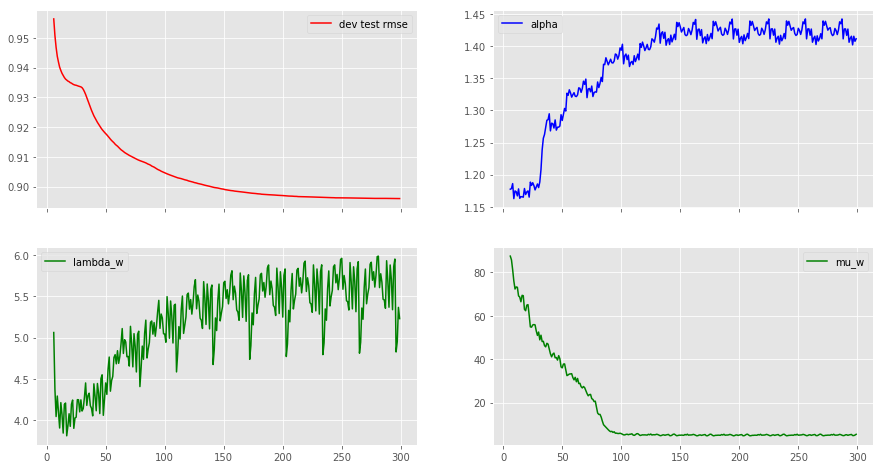

In [26]:
# 開発データでイテレーション回数によるRMSEの推移を確認する
from sklearn.metrics import mean_squared_error
from fastFM import mcmc

# fastFMのパラメーターの指定
n_iter = 300
step_size = 1
seed = 123
rank = 4


# MCMCを使った回帰のFMモデルを初期化する
fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)
fm.fit_predict(X_train, y_train, X_dev_test)

rmse_dev_test = []
rmse_test = []
hyper_param = np.zeros((n_iter -1, 3 + 2 * rank), dtype=np.float64)

# イテレーション回数を変化させて、予測結果の性能とハイパーパラメーターを得る
for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i * seed
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred, y_dev_test)))
    hyper_param[nr, :] = fm.hyper_param_

# 最初の5回は値が落ち着いてないので無視する
values = np.arange(1, n_iter)
x = values * step_size
burn_in = 5
x = x[burn_in:]

# RMSEとハイパーパラメーターをプロットする
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

axes[0, 0].plot(x, rmse_test[burn_in:], label='dev test rmse', color="r")
axes[0, 0].legend()
axes[0, 1].plot(x, hyper_param[burn_in:,0], label='alpha', color="b")
axes[0, 1].legend()
axes[1, 0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color="g")
axes[1, 0].legend()
axes[1, 1].plot(x, hyper_param[burn_in:,3], label='mu_w', color="g")
axes[1, 1].legend()

# 平均二乗誤差
print(np.min(rmse_test))

rank:4	rmse:0.903
rank:8	rmse:0.898
rank:16	rmse:0.896
rank:32	rmse:0.893
rank:64	rmse:0.893


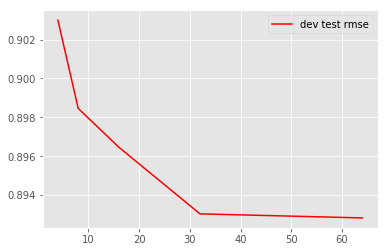

In [19]:
# 行列を圧縮する次数であるrankを大きくした時の性能変化（平均二乗誤差の推移）を見る
n_iter = 100
seed = 333

rmse_test = []
# rankを4l 8, 16, 32, 64で探索する
ranks = [4, 8, 16, 32, 64]

# rankを変えて学習・予測をし、dev testデータに対するRMSEを獲得する
for rank in ranks:
  fm = mcmc.FMRegression(n_iter=n_iter, rank=rank, random_state=seed)
  y_pred = fm.fit_predict(X_train, y_train, X_dev_test)
  rmse = np.sqrt(mean_squared_error(y_pred, y_dev_test))
  rmse_test.append(rmse)
  print('rank:{}\trmse:{:.3f}'.format(rank, rmse))

  
# 各rank毎のRMSEをプロットする → rank32になると平均二乗誤差の変化が落ち着く
plt.plot(ranks, rmse_test, label='dev test rmse', color="r")
plt.legend()

In [20]:
# テストデータでrank32の時を評価する
fm = mcmc.FMRegression(n_iter=300, rank=32, random_state=seed)
fm.fit_predict(X_train, y_train, X_test)
y_pred = fm.fit_predict(X_train, y_train, X_test)
np.sqrt(mean_squared_error(y_pred, y_test))

0.921496840062798

In [21]:
# ユーザーごとに評価値のばらつきがあるため、評価値の標準化を行う（平均二乗誤差が小さくなることが確認できる）
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
y_train_norm = scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
fm = mcmc.FMRegression(n_iter=300, rank=32, random_state=seed)
y_pred = fm.fit_predict(X_train, y_train_norm, X_test)
np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred), y_test))

0.9203443782544464

In [23]:
# ユーザーID、映画ID、公開年、年齢、性別、評価年、評価の情報を加える
lens['user_id'] = lens['user_id'].astype(str)
lens['movie_id'] = lens['movie_id'].astype(str)
lens['year'] = lens['date'].apply(str).str.split('-').str.get(0)
lens['release_year'] = lens['release_date'].apply(str).str.split('-').str.get(2)
lens['year'] = lens['date'].apply(str).str.split('-').str.get(0)
lens['release_year'] = lens['release_date'].apply(str).str.split('-').str.get(2)

# 特徴量の組み合わせを作る
candidate_columns = [
    ['user_id','movie_id', 'release_year', 'age', 'sex', 'year',  'rating'],
    ['user_id','movie_id', 'age', 'sex', 'year',  'rating'],
    ['user_id','movie_id', 'sex', 'year',  'rating'],
    ['user_id','movie_id', 'age', 'sex', 'rating'],    
    ['user_id','movie_id', 'rating'],    
]

# 組み合わせをA〜Eとしてどの組み合わせが良いか学習させる
rmse_test = []

n_iter = 500
seed = 123
rank = 8

# カラム候補群毎に評価を行う
for column in candidate_columns:
    # 欠損値を落とす
    filtered_lens = lens[column].dropna()
    # 入力データをダミー変数に変換する
    v = DictVectorizer()
    X_more_feature = v.fit_transform(list(filtered_lens.drop('rating', axis=1).T.to_dict().values()))
    # 教師となるレーティングを代入する
    y_more_feature = filtered_lens['rating'].tolist()

    # 教師データの学習用と評価用の分割
    X_mf_train, X_mf_test, y_mf_train, y_mf_test = train_test_split(X_more_feature, y_more_feature, test_size=0.1, random_state=42)

    # ratingの正規化をする
    scaler = StandardScaler()
    y_mf_train_norm = scaler.fit_transform(np.array(y_mf_train).reshape(-1, 1)).ravel()

    # MCMCを使ったモデルの学習
    fm = mcmc.FMRegression(n_iter=n_iter, rank=rank, random_state=seed)
    fm.fit_predict(X_mf_train, y_mf_train_norm, X_mf_test)

    # テストデータでの予測結果のRMSEの取得
    y_pred = fm.fit_predict(X_mf_train, y_mf_train_norm, X_mf_test)
    rmse_test.append(np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred.reshape(-1, 1)), y_mf_test)))

print(rmse_test)


[0.8966348934997591, 0.8943648217648883, 0.8850451737482935, 0.8922375852811406, 0.887744557428427]


(0.88, 0.94)

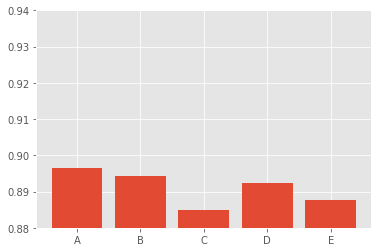

In [24]:
# RMSE(二乗平均平方根誤差)をプロットする（グラフから、CのユーザーID、映画ID、性別、評価年の組み合わせがよいことがわかる）
ind = np.arange(len(rmse_test))
bar = plt.bar(ind, height=rmse_test)
plt.xticks(ind, ('A', 'B', 'C', 'D', 'E'))
plt.ylim((0.88, 0.94))